   amount       date  day  month  year
0   36.72 2023-05-01    1      5  2023
1  173.50 2023-05-01    1      5  2023
2   31.88 2023-05-01    1      5  2023
3  386.61 2023-05-02    2      5  2023
4  190.30 2023-05-02    2      5  2023
   year  month  day  total_so_far  avg_daily_so_far  \
0  2023      5    5        954.58            190.92   
1  2023      5   10       2184.60            218.46   
2  2023      5   15       3084.58            205.64   
3  2023      5   20       3880.21            194.01   
4  2023      5   25       4530.17            181.21   

   num_expensive_transactions  num_transactions  target_total_expenses  
0                           3                 9                5178.38  
1                          10                25                5178.38  
2                          13                36                5178.38  
3                          16                45                5178.38  
4                          18                52                5178.38

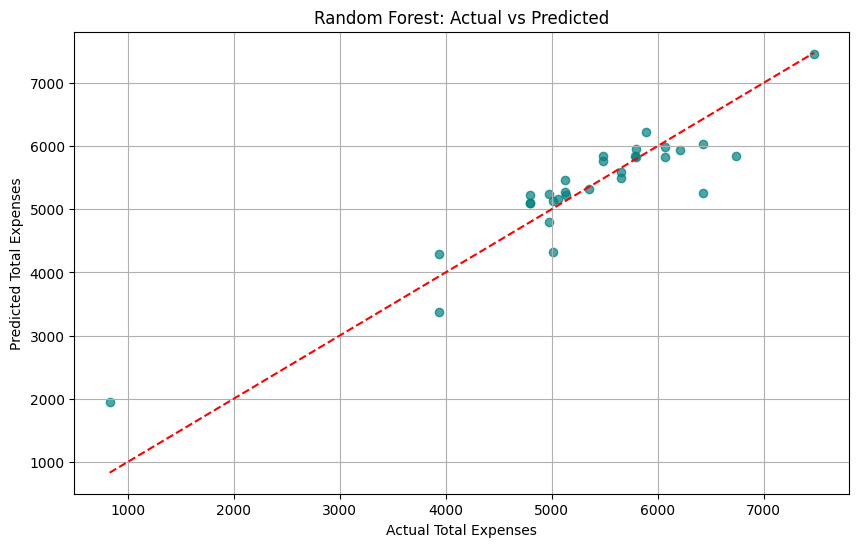

'\ndata = pd.read_csv(\'gastos_simulados.csv\', parse_dates=[\'date\'])\n\n# 🧠 Predict on full data\ndata_features = data.drop(columns=[\'target_total_expenses\'])\ndata[\'predicted_total_expenses\'] = model.predict(data_features).round(2)\n\n# 💾 Save to CSV\ndata.to_csv("snapshot_features_with_predictions.csv", index=False)\nfiles.download("snapshot_features_with_predictions.csv")\n'

In [4]:
# 🧩 Install & Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from google.colab import files
import joblib

# 📥 Load CSV
df = pd.read_csv('simulated-expenses.csv', parse_dates=['date'])

# 🧹 Clean & prepare
df['amount'] = df['amount'].astype(float)
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df = df.drop(['category', 'description/merchant', 'expense_type'], axis=1)

print(df.head())
# 🚀 Parameters
snapshot_days = [5, 10, 15, 20, 25, 28]
expensive_threshold = 100

# 🛠️ Function to generate features for each snapshot
def generate_snapshots(df, snapshot_days):
    all_snapshots = []

    grouped = df.groupby(['year', 'month'])
    for (year, month), group in grouped:
        full_month_total = group['amount'].sum()

        for day_cutoff in snapshot_days:
            partial = group[group['day'] <= day_cutoff]
            if partial.empty:
                continue

            snapshot = {
                'year': year,
                'month': month,
                'day': day_cutoff,
                'total_so_far': partial['amount'].sum(),
                'avg_daily_so_far': partial['amount'].sum() / day_cutoff,
                'num_expensive_transactions': (partial['amount'] > expensive_threshold).sum(),
                'num_transactions': partial.shape[0],
                'target_total_expenses': full_month_total
            }
            all_snapshots.append(snapshot)

    return pd.DataFrame(all_snapshots)

# ⚙️ Generate feature dataset
data = generate_snapshots(df, snapshot_days)

# 🎯 Round financial values to 2 decimals
data[['total_so_far', 'avg_daily_so_far', 'target_total_expenses']] = data[['total_so_far', 'avg_daily_so_far', 'target_total_expenses']].round(2)

# 🔍 Peek at features
print(data.head())

# 🎯 Split features and label
y = data['target_total_expenses']
X = data.drop(columns=['target_total_expenses'])


# 🧪 Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 🌲 Train model
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=1,
    random_state=42
)
model.fit(X_train, y_train)

# 📈 Predict
y_pred = model.predict(X_test)

# 📊 Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\n💥 Evaluation Results:")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Mean Squared Error (MSE): ${mse:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
print(f"R² Score: {r2:.3f}")

# 📉 Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='teal')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Total Expenses")
plt.ylabel("Predicted Total Expenses")
plt.title("Random Forest: Actual vs Predicted")
plt.grid(True)
plt.show()

"""
data = pd.read_csv('gastos_simulados.csv', parse_dates=['date'])

# 🧠 Predict on full data
data_features = data.drop(columns=['target_total_expenses'])
data['predicted_total_expenses'] = model.predict(data_features).round(2)

# 💾 Save to CSV
data.to_csv("snapshot_features_with_predictions.csv", index=False)
files.download("snapshot_features_with_predictions.csv")
"""
#joblib.dump(model, 'expenses_predictor_model.pkl')
#It is predicting, the last ChatGPT response its okey for predicting last day
